<a href="https://colab.research.google.com/github/SophyyCC/GEOG761-Project/blob/RF/Final_version_soil_moisture_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Authenticate project
import ee
ee.Authenticate()
ee.Initialize(project='disco-skyline-467321-e2')

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install packages
!pip install rasterio scikit-image numpy matplotlib
!pip install scipy
!pip install rioxarray
!pip install rasterstats geopandas
!pip install matplotlib-scalebar

In [ ]:
# Import libraries
import os
import zipfile
from collections import defaultdict
from math import ceil
import joblib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
import geopandas as gpd
from shapely.geometry import box, mapping
from pyproj import Transformer
from osgeo import gdal, osr
from scipy.ndimage import uniform_filter
from skimage.morphology import footprint_rectangle
from skimage.filters import rank
import rasterio
from rasterio.warp import reproject, calculate_default_transform
from rasterio.transform import from_origin
from rasterio.io import MemoryFile
from rasterio.windows import from_bounds
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio.plot import show
from rasterio.shutil import copy
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
import xarray as xr
import rioxarray
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
hh1_path = "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HH.tif"

with rasterio.open(hh1_path) as src:
    hh1 = src.read(1)
    hh1_profile = src.profile

hh2_path = "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HH.tif"

with rasterio.open(hh2_path) as src:
    hh2 = src.read(1)
    hh2_profile = src.profile

hv1_path = "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HV.tif"

with rasterio.open(hv1_path) as src:
    hv1 = src.read(1)
    hv1_profile = src.profile

hv2_path = "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HV.tif"

with rasterio.open(hv2_path) as src:
    hv2 = src.read(1)
    hv2_profile = src.profile

In [ ]:
# Define Refined Lee filter
def refined_lee_float(img, window_size=7):
    """
    Refined Lee speckle filter for SAR imagery (linear backscatter)
    Works on float arrays directly (no 0-255 scaling)

    Parameters:
    - img: 2D NumPy array, linear backscatter (float)
    - window_size: odd integer, size of the moving window

    Returns:
    - filtered: 2D NumPy array, speckle-filtered backscatter
    """
    img = np.where(np.isnan(img), 0, img)

    mean_local = uniform_filter(img, size=window_size)
    var_local = uniform_filter((img - mean_local)**2, size=window_size)

    low_var_mask = var_local < np.percentile(var_local, 10)
    var_noise = np.mean(var_local[low_var_mask]) if np.any(low_var_mask) else np.mean(var_local)

    cu = var_noise / (var_local + 1e-12)
    filtered = mean_local + cu * (img - mean_local)
    return filtered

def process_sar_tiles(file_list, out_prefix, window_size=7):
    filtered_tiles = []
    profiles = []

    # Filter tiles
    for f in file_list:
        with rasterio.open(f) as src:
            img = src.read(1).astype(float)
            profile = src.profile
            profiles.append(profile)
            img_filtered = refined_lee_float(img, window_size=window_size)
            filtered_tiles.append(img_filtered)

    datasets = []
    for img, prof in zip(filtered_tiles, profiles):
        memfile = MemoryFile()
        with memfile.open(**prof) as dataset:
            dataset.write(img, 1)
        datasets.append(memfile.open())

    # Mosaic the filtered tiles
    mosaic, out_transform = merge(datasets)
    out_meta = profiles[0].copy()
    out_meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform
    })

    # Convert to dB
    mosaic_linear = mosaic[0]
    mosaic_db = 10 * np.log10(np.clip(mosaic_linear, 1e-6, None))
    mosaic = np.array([mosaic_db])

    # Save mosaic
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(mosaic.shape[1], mosaic.shape[2], out_transform)
    aoi_polygon_proj = box(minx, miny, maxx, maxy)
    aoi_geojson = [mapping(aoi_polygon_proj)]

    # Clip
    with MemoryFile() as memfile:
        with memfile.open(**out_meta) as tmp_ds:
            tmp_ds.write(mosaic)
            clipped, clipped_transform = mask(tmp_ds, aoi_geojson, crop=True)
            clipped_meta = tmp_ds.profile.copy()
            clipped_meta.update({
                "height": clipped.shape[1],
                "width": clipped.shape[2],
                "transform": clipped_transform
            })

    #Save
    out_file = f"/content/drive/My Drive/Colab Notebooks/{out_prefix}_mosaic_filtered.tif"
    with rasterio.open(out_file, "w", **clipped_meta) as dest:
        dest.write(clipped)

    return out_file, clipped, aoi_polygon_proj


hh_files = [
    "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HH.tif",
    "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HH.tif"
]

hh_outfile, hh_clipped, aoi_polygon_proj = process_sar_tiles(hh_files, "HH", window_size=7)

hv_files = [
    "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HV.tif",
    "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HV.tif"
]

hv_outfile, hv_clipped, _ = process_sar_tiles(hv_files, "HV", window_size=7)

In [ ]:
# Define path to the ZIP file in your Drive
zip_path = "/content/drive/My Drive/Colab Notebooks/mfe-land-cover-database-v4-0-class-orders-SHP.zip"

# Define folder
extract_folder = "/content/landcover"
os.makedirs(extract_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("ZIP file extracted successfully!")

# Check the extracted files
print(os.listdir(extract_folder))

ZIP file extracted successfully!
['land-cover-database-v4-0-class-orders.dbf', 'land-cover-database-v4-0-class-orders.txt', 'land-cover-database-v4-0-class-orders.pdf', 'land-cover-database-v4-0-class-orders.shp', 'land-cover-database-v4-0-class-orders.xml', 'land-cover-database-v4-0-class-orders.prj', 'land-cover-database-v4-0-class-orders-ISO.pdf', 'land-cover-database-v4-0-class-orders.cpg', 'land-cover-database-v4-0-class-orders.shx']


In [ ]:
# Load the landcover vector
# Define the expected folder path where the zip was extracted
extract_folder = "/content/landcover"

lc_file = os.path.join(extract_folder, "land-cover-database-v4-0-class-orders.shp")
lc = gpd.read_file(lc_file)

# Keep only 2008 columns
lc_2008 = lc[['LCDB_UID', 'Class_2008', 'Name_2008', 'geometry']].copy()

# Rename columns
lc_2008 = lc_2008.rename(columns={'Class_2008': 'LC_Class', 'Name_2008': 'LC_Name'})

In [ ]:
target_crs = "EPSG:32759"
lc_2008_proj = lc_2008.to_crs(target_crs)
print("Landcover reprojected CRS:", lc_2008_proj.crs)

# Clip Landcover to HH mosaic AOI
# Convert AOI polygon to GeoDataFrame
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_polygon_proj], crs="EPSG:32759")
aoi_polygon_proj = aoi_gdf.geometry.iloc[0]

# Clip landcover
lc_2008_clipped = gpd.clip(lc_2008_proj, aoi_gdf)
print("Landcover clipped. Number of features:", len(lc_2008_clipped))

Landcover reprojected CRS: EPSG:32759
Landcover clipped. Number of features: 14911


In [ ]:
ref_raster = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
lc_gdf = lc_2008_clipped
out_lc_raster = "/content/drive/My Drive/Colab Notebooks/landcover_raster.tif"

# Make a mapping of land cover class -> integer code
classes = np.sort(lc_gdf['LC_Class'].unique())
class_to_code = {int(c): i+1 for i, c in enumerate(classes)}
print("Landcover classes -> codes:", class_to_code)

# Add a column with the integer code
lc_gdf['lc_code'] = lc_gdf['LC_Class'].map(class_to_code).astype(np.int32)

with rasterio.open(ref_raster) as ref:
    ref_meta = ref.meta.copy()
    out_transform = ref.transform
    out_crs = ref.crs
    out_height = ref.height
    out_width = ref.width
    out_dtype = rasterio.uint16 if len(classes) > 255 else rasterio.uint8

shapes = ((geom, value) for geom, value in zip(lc_gdf.geometry, lc_gdf['lc_code']))

# Rasterise
lc_raster_arr = rasterize(
    shapes=shapes,
    out_shape=(out_height, out_width),
    fill=0,
    transform=out_transform,
    dtype=out_dtype,
    all_touched=True
)

# Save raster
out_meta = ref_meta.copy()
out_meta.update({
    'count': 1,
    'dtype': lc_raster_arr.dtype,
    'compress': 'lzw'
})

with rasterio.open(out_lc_raster, 'w', **out_meta) as dst:
    dst.write(lc_raster_arr, 1)

Landcover classes -> codes: {1: 1, 2: 2, 5: 3, 6: 4, 10: 5, 12: 6, 16: 7, 20: 8, 21: 9, 22: 10, 30: 11, 33: 12, 40: 13, 41: 14, 43: 15, 44: 16, 45: 17, 46: 18, 47: 19, 50: 20, 51: 21, 52: 22, 54: 23, 55: 24, 56: 25, 58: 26, 64: 27, 68: 28, 69: 29, 71: 30}


In [ ]:
dem_path = "/content/drive/My Drive/Colab Notebooks/SRTM_DEM.tif"

with rasterio.open(dem_path) as src:
    dem = src.read(1)
    dem_profile = src.profile

print("DEM shape:", dem.shape)
print("DEM CRS:", dem_profile['crs'])

DEM shape: (3515, 6191)
DEM CRS: EPSG:4326


In [ ]:
dem_path = "/content/drive/My Drive/Colab Notebooks/SRTM_DEM.tif"
dem_reproj_path = "/content/drive/My Drive/Colab Notebooks/SRTM_DEM_32759.tif"
dem_clipped_path = "/content/drive/My Drive/Colab Notebooks/DEM_clipped.tif"

target_crs = "EPSG:32759"

# Reproject DEM to EPSG:32759
with rasterio.open(dem_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    dem_reproj = np.empty((height, width), dtype=src.dtypes[0])
    reproject(
        source=rasterio.band(src, 1),
        destination=dem_reproj,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=target_crs,
        resampling=Resampling.bilinear
    )

# Save reprojected DEM
with rasterio.open(dem_reproj_path, "w", **kwargs) as dst:
    dst.write(dem_reproj, 1)

print("DEM reprojected to EPSG:32759.")

# Clip DEM to AOI
aoi_geojson = [mapping(aoi_polygon_proj)]

with rasterio.open(dem_reproj_path) as src:
    dem_clipped, dem_transform = mask(src, shapes=aoi_geojson, crop=True)
    dem_clipped = dem_clipped[0]
    dem_meta = src.meta.copy()
    dem_meta.update({
        "height": dem_clipped.shape[0],
        "width": dem_clipped.shape[1],
        "transform": dem_transform,
        "count": 1,
        "dtype": dem_clipped.dtype
    })

with rasterio.open(dem_clipped_path, "w", **dem_meta) as dst:
    dst.write(dem_clipped, 1)

print("DEM clipped to AOI:", dem_clipped_path)

DEM reprojected to EPSG:32759.
DEM clipped to AOI: /content/drive/My Drive/Colab Notebooks/DEM_clipped.tif


In [ ]:

modis_hdf = "/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf"

dataset = gdal.Open(modis_hdf, gdal.GA_ReadOnly)
if dataset is None:
    print("Could not open HDF file.")
else:
    print("HDF file opened successfully!")
    subdatasets = dataset.GetSubDatasets()
    print("Available subdatasets:")
    for sd in subdatasets:
        print(sd[0])

/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


HDF file opened successfully!
Available subdatasets:
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days NDVI"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days VI Quality"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days red reflectance"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days NIR reflectance"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250

In [ ]:

modis_hdf = "/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf"

ndvi_path = f'HDF4_EOS:EOS_GRID:"{modis_hdf}":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days NDVI"'
ndvi_dataset = gdal.Open(ndvi_path, gdal.GA_ReadOnly)

if ndvi_dataset is None:
    print(f"Could not open NDVI subdataset: {ndvi_path}")
else:
    ndvi = ndvi_dataset.ReadAsArray().astype(np.float32)
    ndvi = ndvi * 0.0001  # Apply MODIS scale factor
    print("NDVI data read successfully. Shape:", ndvi.shape)

    ndvi_dataset = None


NDVI data read successfully. Shape: (4800, 4800)


In [ ]:
ndvi_tiff = "/content/drive/My Drive/Colab Notebooks/modis_ndvi.tif"

ndvi_dataset = gdal.Open(ndvi_path)
gt = ndvi_dataset.GetGeoTransform()
proj = ndvi_dataset.GetProjection()
ndvi_dataset = None

# Save NDVI as GeoTIFF
driver = gdal.GetDriverByName("GTiff")
rows, cols = ndvi.shape
out_ds = driver.Create(ndvi_tiff, cols, rows, 1, gdal.GDT_Float32)
out_ds.SetGeoTransform(gt)
out_ds.SetProjection(proj)
out_ds.GetRasterBand(1).WriteArray(ndvi)
out_ds.FlushCache()
out_ds = None

print("NDVI saved as GeoTIFF:", ndvi_tiff)

NDVI saved as GeoTIFF: /content/drive/My Drive/Colab Notebooks/modis_ndvi.tif


In [ ]:
ndvi_tiff = "/content/drive/My Drive/Colab Notebooks/modis_ndvi.tif"
with rasterio.open(ndvi_tiff) as src:
    ndvi_data = src.read(1)
    ndvi_meta = src.meta.copy()
    print("Original NDVI CRS:", src.crs)
    print("Original NDVI bounds:", src.bounds)

# Reproject NDVI to EPSG:32759
target_crs = "EPSG:32759"

with rasterio.open(ndvi_tiff) as src:
    src_crs = src.crs
    src_bounds = src.bounds
    src_width = src.width
    src_height = src.height

transform, width, height = calculate_default_transform(
    src_crs, target_crs, src_width, src_height, *src_bounds
)

ndvi_reproj = np.empty((height, width), dtype=np.float32)

with rasterio.open(ndvi_tiff) as src:
    reproject(
        source=rasterio.band(src, 1),
        destination=ndvi_reproj,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=target_crs,
        resampling=Resampling.bilinear
    )

ndvi_meta.update({
    "crs": target_crs,
    "transform": transform,
    "height": height,
    "width": width,
    "count": 1,
    "dtype": ndvi_reproj.dtype
})


# Clip NDVI to HH mosaic AOI
aoi_geojson = [mapping(aoi_polygon_proj)]

# Create raster with the reprojected NDVI
with rasterio.io.MemoryFile() as memfile:
    with memfile.open(**ndvi_meta) as dataset:
        dataset.write(ndvi_reproj, 1)

        # Clip to AOI
        ndvi_clipped, ndvi_transform = mask(
            dataset,
            shapes=aoi_geojson,
            crop=True
        )

# Update metadata
ndvi_meta.update({
    "height": ndvi_clipped.shape[1],
    "width": ndvi_clipped.shape[2],
    "transform": ndvi_transform
})

# Save clipped NDVI
ndvi_clipped_path = "/content/drive/My Drive/Colab Notebooks/modis_ndvi_clipped.tif"
with rasterio.open(ndvi_clipped_path, "w", **ndvi_meta) as dst:
    dst.write(ndvi_clipped)

print("NDVI reprojected and clipped to AOI:", ndvi_clipped_path)

Original NDVI CRS: PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Original NDVI bounds: BoundingBox(left=13343406.236, bottom=-5559752.598333, right=14455356.755667, top=-4447802.078667)
NDVI reprojected and clipped to AOI: /content/drive/My Drive/Colab Notebooks/modis_ndvi_clipped.tif


In [ ]:
sm_path = "/content/drive/My Drive/Colab Notebooks/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc"

ds = xr.open_dataset(sm_path)
print(ds)

<xarray.Dataset> Size: 29MB
Dimensions:         (time: 1, lat: 720, lon: 1440)
Coordinates:
  * time            (time) datetime64[ns] 8B 2010-10-27
  * lat             (lat) float32 3kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    sm              (time, lat, lon) float32 4MB ...
    sm_uncertainty  (time, lat, lon) float32 4MB ...
    flag            (time, lat, lon) float32 4MB ...
    freqbandID      (time, lat, lon) int16 2MB ...
    dnflag          (time, lat, lon) int8 1MB ...
    mode            (time, lat, lon) int8 1MB ...
    sensor          (time, lat, lon) int32 4MB ...
    t0              (time, lat, lon) datetime64[ns] 8MB ...
Attributes: (12/44)
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    institution:                  TU Wien (AUT); VanderSat B.V. (NL); Planet ...
    contact:                      cci_sm_contact@eodc.eu
    source:   

In [ ]:
hh_mosaic_path = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
hv_mosaic_path = "/content/drive/My Drive/Colab Notebooks/HV_mosaic_filtered.tif"
ref_path = hh_mosaic_path

In [ ]:
sm_path = "/content/drive/My Drive/Colab Notebooks/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc"
hh_mosaic_path = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
out_tiff = "cci_soilm.tif"

# Load ESA CCI soil moisture
ds = xr.open_dataset(sm_path)
soil_moisture = ds['sm'].isel(time=0).values

# Convert xarray to raster with correct CRS
soil_moisture_da = ds['sm'].isel(time=0)

# Scale to m³/m³
soil_moisture_da = soil_moisture_da * 0.01
soil_moisture_da = soil_moisture_da.clip(0.0, 1.0)

soil_moisture_da = soil_moisture_da.rio.write_crs("EPSG:4326")

with rasterio.open(hh_mosaic_path) as ref:
    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_height = ref.height
    ref_width = ref.width

# Reproject soil moisture to HH mosaic alignment
soil_moisture_aligned = soil_moisture_da.rio.reproject(
    dst_crs=ref_crs,
    shape=(ref_height, ref_width),
    transform=ref_transform,
    resampling=Resampling.bilinear
)

# Save aligned raster
out_tiff = "cci_soilm_aligned.tif"
soil_moisture_aligned.rio.to_raster(out_tiff)
print("Aligned CCI soil moisture saved as:", out_tiff)

# Verify the range
print(f"Soil moisture range: {float(soil_moisture_aligned.min()):.3f} to {float(soil_moisture_aligned.max()):.3f} m³/m³")

# Get latitude and longitude
lat = ds['lat'].values
lon = ds['lon'].values

ulx = lon.min()
uly = lat.max()
xres = lon[1] - lon[0]
yres = lat[0] - lat[1]

cci_transform = from_origin(ulx, uly, xres, -yres)


Aligned CCI soil moisture saved as: cci_soilm_aligned.tif
Soil moisture range: 0.003 to 0.003 m³/m³


In [ ]:
dem_clipped_path = "/content/drive/My Drive/Colab Notebooks/DEM_clipped.tif"
slope_path = "/content/drive/My Drive/Colab Notebooks/DEM_slope.tif"
aspect_path = "/content/drive/My Drive/Colab Notebooks/DEM_aspect.tif"

dem_ds = gdal.Open(dem_clipped_path)
gdal.DEMProcessing(slope_path, dem_ds, "slope", format="GTiff", slopeFormat="degree")
gdal.DEMProcessing(aspect_path, dem_ds, "aspect", format="GTiff")
dem_ds = None

# Read slope and aspect as arrays
with rasterio.open(slope_path) as src:
    slope = src.read(1)
with rasterio.open(aspect_path) as src:
    aspect = src.read(1)

In [ ]:
hh_filtered_mosaic = hh_clipped[0]
hv_filtered_mosaic = hv_clipped[0]
soil_moisture_clipped = soil_moisture_aligned

In [ ]:
ref_path = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
with rasterio.open(ref_path) as ref:
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_height = ref.height
    ref_width = ref.width

def align_raster_to_ref(src_array, src_meta, ref_transform, ref_crs, ref_height, ref_width):
    aligned = np.empty((ref_height, ref_width), dtype=src_array.dtype)
    reproject(
        source=src_array,
        destination=aligned,
        src_transform=src_meta['transform'],
        src_crs=src_meta['crs'],
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=Resampling.bilinear
    )
    return aligned

# DEM
dem_clipped_path = "/content/drive/My Drive/Colab Notebooks/DEM_clipped.tif"
with rasterio.open(dem_clipped_path) as src:
    dem_aligned = align_raster_to_ref(src.read(1), src.profile, ref_transform, ref_crs, ref_height, ref_width)

# Slope
slope_path = "/content/drive/My Drive/Colab Notebooks/DEM_slope.tif"
with rasterio.open(slope_path) as src:
    slope_aligned = align_raster_to_ref(src.read(1), src.profile, ref_transform, ref_crs, ref_height, ref_width)

# Aspect
aspect_path = "/content/drive/My Drive/Colab Notebooks/DEM_aspect.tif"
with rasterio.open(aspect_path) as src:
    aspect_aligned = align_raster_to_ref(src.read(1), src.profile, ref_transform, ref_crs, ref_height, ref_width)

# NDVI
ndvi_clipped_path = "/content/drive/My Drive/Colab Notebooks/modis_ndvi_clipped.tif"
with rasterio.open(ndvi_clipped_path) as src:
    ndvi_aligned = align_raster_to_ref(src.read(1), src.meta, ref_transform, ref_crs, ref_height, ref_width)

# CCI Soil Moisture
sm_raster = "cci_soilm_aligned.tif"
with rasterio.open(sm_raster) as src:
    sm_aligned = align_raster_to_ref(src.read(1), src.meta, ref_transform, ref_crs, ref_height, ref_width)

# HV mosaic
hv_mosaic_path = "/content/drive/My Drive/Colab Notebooks/HV_mosaic_filtered.tif"
hv_aligned = hv_filtered_mosaic[0]
if hv_aligned.shape != (ref_height, ref_width):
    with rasterio.open(hv_mosaic_path) as src:
        hv_aligned = align_raster_to_ref(src.read(1), src.profile, ref_transform, ref_crs, ref_height, ref_width)

In [ ]:
# Low-RAM stratified sampling + RF training + blockwise prediction
# Samples stratified by landcover with per-class caps

# Parameters
ref_path = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
predictor_paths = [
    "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif",
    "/content/drive/My Drive/Colab Notebooks/HV_mosaic_filtered.tif",
    "/content/drive/My Drive/Colab Notebooks/DEM_clipped.tif",
    "/content/drive/My Drive/Colab Notebooks/DEM_slope.tif",
    "/content/drive/My Drive/Colab Notebooks/DEM_aspect.tif",
    "/content/drive/My Drive/Colab Notebooks/modis_ndvi_clipped.tif",
    "/content/drive/My Drive/Colab Notebooks/landcover_raster.tif"
]
target_path = "cci_soilm_aligned.tif"

# Sampling
max_per_class = 1000
total_random_extra = 1000
desired_total = None
rng = np.random.default_rng(42)

# RF parameters
rf_params = dict(n_estimators=200, n_jobs=-1, random_state=42)

# Block scanning size for building samples
scan_block = 512

# Block size for prediction
pred_block = 128

if not os.path.exists(ref_path):
    print(f"Error: Reference file not found at {ref_path}")
else:
    with rasterio.open(ref_path) as ref:
        ref_meta = ref.meta.copy()
        height, width = ref.height, ref.width
        ref_transform = ref.transform
        ref_crs = ref.crs

    print("Reference:", width, "x", height, " CRS:", ref_crs)

    # Create a WarpedVRT for landcover raster and target raster
    # Create VRTs for predictors later for sampling and prediction
    def make_vrt(path, resampling=Resampling.bilinear):
        if not os.path.exists(path):
            print(f"Error: Source file for VRT not found at {path}")
            return None, None
        src = rasterio.open(path)
        vrt = WarpedVRT(
            src,
            crs=ref_crs,
            transform=ref_transform,
            width=width,
            height=height,
            resampling=resampling
        )
        return src, vrt

    lc_src, lc_vrt = make_vrt(predictor_paths[6], resampling=Resampling.nearest)

    t_src, t_vrt = make_vrt(target_path, resampling=Resampling.bilinear)

    predictor_srcs = []
    predictor_vrts = []
    for idx, p in enumerate(predictor_paths):
        if idx == 6:
            # Use nearest resampling for landcover
            predictor_srcs.append(lc_src)
            predictor_vrts.append(lc_vrt)
        else:
            # Use bilinear resampling for other predictors
            src, vrt = make_vrt(p, resampling=Resampling.bilinear)
            predictor_srcs.append(src)
            predictor_vrts.append(vrt)


    # Build stratified sample indices
    lc_band_idx = 6
    class_indices = defaultdict(list)
    extra_reservoir = []
    num_seen_for_reservoir = 0

    rows_total = 0
    for i in range(0, height, scan_block):
        i_max = min(i + scan_block, height)
        for j in range(0, width, scan_block):
            j_max = min(j + scan_block, width)
            window = ((i, i_max), (j, j_max))

            # Read landcover and target for this block
            lc_block = lc_vrt.read(1, window=window)
            t_block = t_vrt.read(1, window=window)

            # Target non-nan values and non-0 landcover
            block_valid = (~np.isnan(t_block)) & (lc_block != 0)

            if not block_valid.any():
                continue

            # Coordinates within block where valid
            local_rows, local_cols = np.where(block_valid)
            # Map to global coordinates
            global_rows = local_rows + i
            global_cols = local_cols + j

            # Group indices by class within the block
            unique_classes = np.unique(lc_block[block_valid])
            for cl in unique_classes:
                if cl == 0:
                    continue
                class_mask = (lc_block == cl) & block_valid
                lr, lc = np.where(class_mask)
                if lr.size == 0:
                    continue
                gr = lr + i
                gc = lc + j
                coords = list(zip(gr.tolist(), gc.tolist()))

                need = max_per_class - len(class_indices[cl])
                if need <= 0:
                    for coord in coords:
                        num_seen_for_reservoir += 1
                        if len(extra_reservoir) < total_random_extra:
                            extra_reservoir.append(coord)
                        else:
                            k = rng.integers(0, num_seen_for_reservoir)
                            if k < total_random_extra:
                                extra_reservoir[k] = coord
                    continue

                if len(coords) <= need:
                    picked = coords
                else:
                    idxs = rng.choice(len(coords), size=need, replace=False)
                    picked = [coords[int(ii)] for ii in idxs]

                class_indices[cl].extend(picked)

                picked_set = set(picked)
                for coord in coords:
                    if coord in picked_set:
                        continue
                    num_seen_for_reservoir += 1
                    if len(extra_reservoir) < total_random_extra:
                        extra_reservoir.append(coord)
                    else:
                        k = rng.integers(0, num_seen_for_reservoir)
                        if k < total_random_extra:
                                extra_reservoir[k] = coord

            rows_total += len(global_rows)

    print("Per-class counts collected:")
    for cl, coords in class_indices.items():
        print(" class", cl, ":", len(coords))
    print("Reservoir extras collected:", len(extra_reservoir))

    sample_idx = []
    seen = set()
    for cl, coords in class_indices.items():
        for coord in coords:
            if coord not in seen:
                sample_idx.append(coord)
                seen.add(coord)

    for coord in extra_reservoir:
        if coord not in seen:
            sample_idx.append(coord)
            seen.add(coord)
        if desired_total is not None and len(sample_idx) >= desired_total:
            break

    print("Total training samples after combining:", len(sample_idx))

    if desired_total is not None and len(sample_idx) > desired_total:
        sample_idx = list(rng.choice(sample_idx, size=desired_total, replace=False))
        print("Downsampled to desired_total:", desired_total)

    # Extract sample features
    def rc_to_xy(transform, row, col):
        x, y = transform * (col + 0.5, row + 0.5)
        return (x, y)

    coords_xy = [rc_to_xy(ref_transform, r, c) for (r, c) in sample_idx]
    n_samples = len(coords_xy)
    print("Sampling predictors for n_samples =", n_samples)

    # Create array for X with dtype float32 but last col is landcover integer cast to float
    n_features = len(predictor_vrts)  # Number of predictor rasters
    X = np.empty((n_samples, n_features), dtype=np.float32)
    y = np.empty((n_samples,), dtype=np.float32)

    # Sample target using t_vrt
    for idx, val in enumerate(t_vrt.sample(coords_xy)):
        y[idx] = float(val[0]) if val is not None else np.nan

    # Sample predictors
    for f_idx, vrt in enumerate(predictor_vrts):
        vals = list(vrt.sample(coords_xy))
        colvals = np.array([v[0] if v is not None else np.nan for v in vals], dtype=np.float32)
        X[:, f_idx] = colvals

    # Mask out any samples with nan predictors or nan target
    valid_rows = (~np.isnan(X).any(axis=1)) & (~np.isnan(y))
    print("Valid training samples after removing NaNs:", valid_rows.sum())

    X = X[valid_rows]
    y = y[valid_rows]
    print("Final training matrix:", X.shape, "y:", y.shape)

    # Train random forest model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(**rf_params)
    print("Training RF on", X_train.shape[0], "samples...")
    rf.fit(X_train, y_train)
    print("RF training complete.")

    # Quick validation
    y_pred = rf.predict(X_test)
    from sklearn.metrics import mean_squared_error, r2_score
    print("Holdout RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("Holdout R2:", r2_score(y_test, y_pred))

    # Save model
    joblib.dump(rf, "/content/drive/My Drive/Colab Notebooks/rf_sm_model.joblib")
    print("Saved RF model.")

    out_pred_path = "/content/drive/My Drive/Colab Notebooks/SM_RF_predicted.tif"

    # Define nodata value
    nodata_val = -9999.0

    # Update metadata
    out_meta = ref_meta.copy()
    out_meta.update(dtype=rasterio.float32, count=1, nodata=nodata_val)

    # Create output file
    with rasterio.open(out_pred_path, "w", **out_meta) as dst_out:
        for i in range(0, height, pred_block):
            i_max = min(i + pred_block, height)
            for j in range(0, width, pred_block):
                j_max = min(j + pred_block, width)
                window = ((i, i_max), (j, j_max))

                # Read predictors
                block_stack = []
                for f_idx, vrt in enumerate(predictor_vrts):
                    arr = vrt.read(1, window=window).astype(np.float32)
                    block_stack.append(arr)

                # Stack
                block_stack = np.stack(block_stack, axis=-1)
                h_blk, w_blk, nf = block_stack.shape

                # Flatten for prediction
                flat = block_stack.reshape(-1, nf)

                # Mask invalid pixels
                flat[flat == -9999] = np.nan
                valid_flat = (~np.isnan(flat)).all(axis=1) & (flat[:, lc_band_idx] != 0)

                # Initialise prediction array with nodata
                preds = np.full(flat.shape[0], nodata_val, dtype=np.float32)

                # Predict only on valid pixels
                if valid_flat.any():
                    X_blk = flat[valid_flat, :].astype(np.float32)
                    preds[valid_flat] = rf.predict(X_blk).astype(np.float32)

                # Reshape and write to output
                predicted_block = preds.reshape(h_blk, w_blk)
                dst_out.write(predicted_block, 1, window=window)

    print("Prediction complete. Output:", out_pred_path)

Reference: 7975 x 10511  CRS: EPSG:32759
Per-class counts collected:
 class 6 : 1000
 class 7 : 1000
 class 8 : 1000
 class 13 : 1000
 class 14 : 1000
 class 15 : 1000
 class 16 : 1000
 class 17 : 1000
 class 21 : 1000
 class 22 : 1000
 class 23 : 1000
 class 24 : 1000
 class 26 : 1000
 class 29 : 1000
 class 30 : 1000
 class 9 : 1000
 class 11 : 1000
 class 27 : 1000
 class 28 : 1000
 class 25 : 922
 class 4 : 995
 class 20 : 1000
 class 2 : 1000
 class 1 : 1000
 class 19 : 217
 class 3 : 107
 class 12 : 1000
Reservoir extras collected: 1000
Total training samples after combining: 26241
Sampling predictors for n_samples = 26241
Valid training samples after removing NaNs: 26241
Final training matrix: (26241, 7) y: (26241,)
Training RF on 20992 samples...
RF training complete.
Holdout RMSE: 8.052196696626628e-06
Holdout R2: 0.9904546442212241
Saved RF model.
Prediction complete. Output: /content/drive/My Drive/Colab Notebooks/SM_RF_predicted.tif


In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

r2_scores = []
rmse_scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf_fold = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )
    rf_fold.fit(X_train, y_train)

    # Predict and calculate metrics
    y_pred = rf_fold.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Print mean ± std
print(f"Mean R²:   {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.3} ± {np.std(rmse_scores):.3f} m³/m³")

Mean R²:   0.990 ± 0.001
Mean RMSE: 8.34e-06 ± 0.000 m³/m³


In [ ]:
first_rf_path = "/content/drive/My Drive/Colab Notebooks/SM_RF_predicted.tif"

output_path = "/content/drive/My Drive/Colab Notebooks/SM_RF_predicted_for_RF2_2193.tif"

target_crs = "EPSG:2193"

with rasterio.open(first_rf_path) as src:
    data = src.read(1)
    nodata = src.nodata
    src_crs = src.crs
    src_transform = src.transform
    meta = src.meta.copy()

# Mask invalid pixels
valid_mask = data != nodata
data_clean = np.where(valid_mask, data, nodata)

# Reproject to EPSG:2193
transform, width, height = calculate_default_transform(
    src_crs, target_crs, src.width, src.height, *src.bounds
)

# Update metadata
meta.update({
    "crs": target_crs,
    "transform": transform,
    "width": width,
    "height": height,
    "dtype": data.dtype,
    "nodata": nodata
})

# Create array
data_reproj = np.empty((height, width), dtype=data.dtype)

# Perform reprojection
reproject(
    source=data_clean,
    destination=data_reproj,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=transform,
    dst_crs=target_crs,
    resampling=Resampling.nearest,
    src_nodata=nodata,
    dst_nodata=nodata
)

with rasterio.open(output_path, "w", **meta) as dst:
    dst.write(data_reproj, 1)

print(f"Reprojected raster saved to: {output_path}")
print(f"Original CRS: {src_crs}, New CRS: {target_crs}")
print(f"Valid pixels: {np.sum(valid_mask)} / {data.size}")


Reprojected raster saved to: /content/drive/My Drive/Colab Notebooks/SM_RF_predicted_for_RF2_2193.tif
Original CRS: EPSG:32759, New CRS: EPSG:2193
Valid pixels: 42265676 / 83825225


In [ ]:
# Convert to cloud-optimised GeoTIFF using lossless deflate compression lossless
src_path = "/content/drive/My Drive/Colab Notebooks/SM_RF_predicted_for_RF2_2193.tif"
cog_path = "/content/drive/My Drive/Colab Notebooks/SM_RF_predicted_for_RF2_2193_COG.tif"

copy(
    src_path,
    cog_path,
    driver='COG',
    compress='DEFLATE'
)

print(f"COG raster saved to: {cog_path}")


COG raster saved to: /content/drive/My Drive/Colab Notebooks/SM_RF_predicted_for_RF2_2193_COG.tif


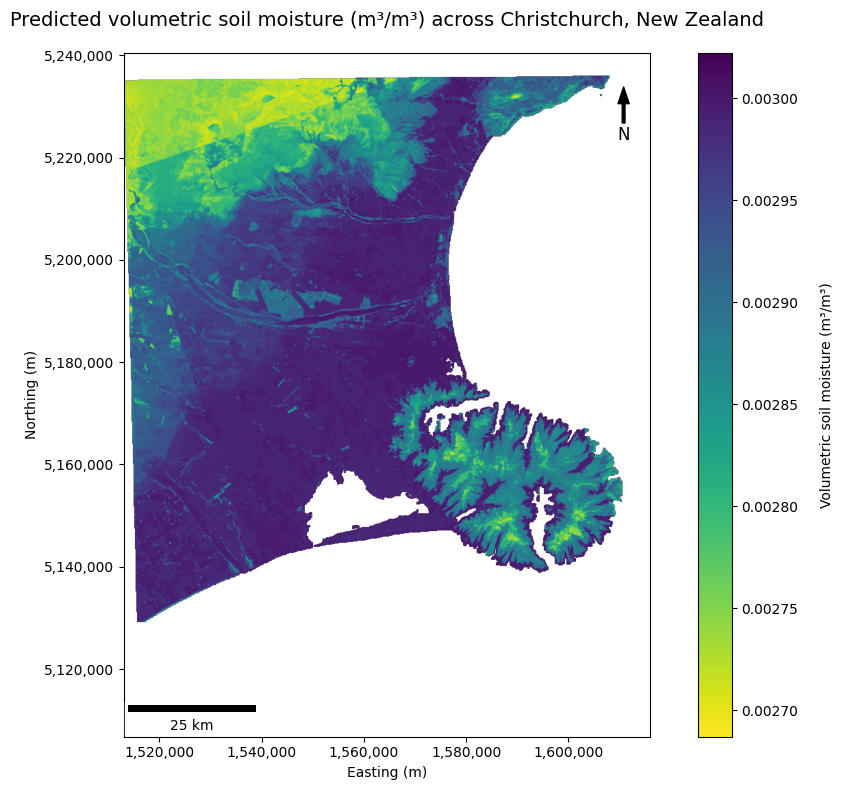

In [ ]:
with rasterio.open(cog_path) as src:
    # Downsample
    max_size = 1000
    scale = min(max_size / src.width, max_size / src.height)
    out_shape = (1, int(src.height * scale), int(src.width * scale))
    data = src.read(
        1,
        out_shape=out_shape,
        resampling=Resampling.bilinear
    )

    transform = src.transform * src.transform.scale(
        src.width / data.shape[1],
        src.height / data.shape[0]
    )
    nodata = src.nodata
    crs = src.crs

# Mask nodata
data_masked = np.where(data != nodata, data, np.nan)

fig, ax = plt.subplots(figsize=(10, 8))
im = show(data_masked, transform=transform, cmap='viridis_r', ax=ax)
cbar = plt.colorbar(im.get_images()[0], ax=ax, label='Volumetric soil moisture (m³/m³)')
cbar.set_label('Volumetric soil moisture (m³/m³)', labelpad=15)

# Set title and axis labels
ax.set_title('Predicted volumetric soil moisture (m³/m³) across Christchurch, New Zealand', fontsize=14, pad=20)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

ax.ticklabel_format(style='plain', axis='both')

def format_ticks(x, pos):
    return f'{x:,.0f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Add a north arrow
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.88),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=2, headwidth=8),
            ha='center', va='center', fontsize=12, color='black')

# Add scale bar
scalebar = ScaleBar(
    dx=1,
    units="m",
    location='lower left',
    length_fraction=0.25
)
ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

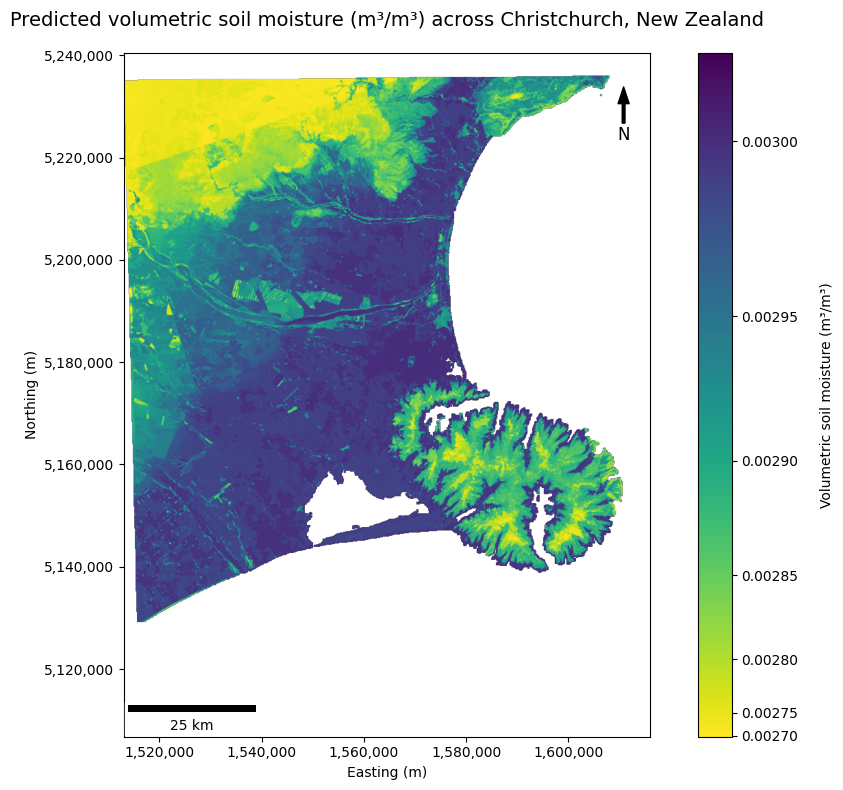

In [ ]:
with rasterio.open(cog_path) as src:
    # Downsample
    max_size = 1000
    scale = min(max_size / src.width, max_size / src.height)
    out_shape = (1, int(src.height * scale), int(src.width * scale))
    data = src.read(
        1,
        out_shape=out_shape,
        resampling=Resampling.bilinear
    )

    transform = src.transform * src.transform.scale(
        src.width / data.shape[1],
        src.height / data.shape[0]
    )
    nodata = src.nodata
    crs = src.crs

# Mask nodata
data_masked = np.where(data != nodata, data, np.nan)

# Define nonlinear normalization
gamma_norm = colors.PowerNorm(gamma=2, vmin=np.nanmin(data_masked), vmax=np.nanmax(data_masked))

fig, ax = plt.subplots(figsize=(10, 8))
im = show(data_masked, transform=transform, cmap='viridis_r', ax=ax, norm=gamma_norm)
cbar = plt.colorbar(im.get_images()[0], ax=ax)
cbar.set_label('Volumetric soil moisture (m³/m³)', labelpad=15)

# Set title and axis labels
ax.set_title('Predicted volumetric soil moisture (m³/m³) across Christchurch, New Zealand', fontsize=14, pad=20)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

ax.ticklabel_format(style='plain', axis='both')

def format_ticks(x, pos):
    return f'{x:,.0f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Add north arrow
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.88),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=2, headwidth=8),
            ha='center', va='center', fontsize=12, color='black')

# Add scale bar
scalebar = ScaleBar(
    dx=1,
    units="m",
    location='lower left',
    length_fraction=0.25
)
ax.add_artist(scalebar)

plt.tight_layout()
plt.show()